<h3 style="text-align: center;"><b>ПРОЕКТ. Image Generation. CycleGAN.



 Проект выполнен с использованием кода из блокнота ДЗ GAN

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

from pathlib import Path
from PIL import Image
import itertools
from torchsummary import summary
from torch.optim import lr_scheduler

from torch.autograd import Variable

## Часть 1. Подготовка данных

В качестве обучающей выборки - часть датасета

https://www.kaggle.com/yudhaislamisulistya/plants-type-datasets?select=dataset_type_of_plants

Датасет содержит изображения овощей, возьмем кукурузу и баклажан

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
curr_dir = 'data'
os.makedirs(curr_dir, exist_ok=True)

In [ ]:
!unzip -q /content/gdrive/MyDrive/corn_eggplant/corn_train.zip -d data/trainA
!unzip -q /content/gdrive/MyDrive/corn_eggplant/corn_test.zip -d data/testA
!unzip -q /content/gdrive/MyDrive/corn_eggplant/eggplant_train.zip -d data/trainB
!unzip -q /content/gdrive/MyDrive/corn_eggplant/eggplant_test.zip -d data/testB

In [ ]:
image_size = 256
batch_size = 4
stats = (0, 0, 0), (1, 1, 1)

In [ ]:
def PRE_tr(image):
  return transformations_0(image)

def image2tensor(image, sh=3):
  if sh==3:
    return transformations(image)
  else:
    return transformations_1(image)

In [ ]:
transformations_0=tt.Compose([
    tt.ToTensor()])

transformations=tt.Compose([
    tt.Resize((image_size, image_size)),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize((0, 0, 0), (1, 1, 1))])

transformations_1=tt.Compose([
    tt.Resize((image_size, image_size)),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize((0), (1))]) 


number_images=832
DATA_DIR_A=Path('/content/data/trainA')
DATA_DIR_B=Path('/content/data/trainB')

files_A=list(DATA_DIR_A.rglob('*.jpg'))
files_B=list(DATA_DIR_B.rglob('*.jpg'))
image_folder_A = Path('/content/data/trainA')
image_folder_B = Path('/content/data/trainB')

train_ds_A =[]
train_ds_B = []

j=0

root_A = '/content/data/trainA'
root_B = '/content/data/trainB'
for idx, fname in tqdm(enumerate(files_A), total = len(files_A) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_A = Image.open(os.path.join(DATA_DIR_A, root_A, fname)).convert('RGB')
    train_ds_A.append(image2tensor(image_temp_A))
    j+=1
j=0
for idx, fname in tqdm(enumerate(files_B), total = len(files_B) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_B = Image.open(os.path.join(DATA_DIR_B, root_B, fname)).convert('RGB')
    if PRE_tr(image_temp_B).size(0) == 1:
      arr1 = image2tensor(image_temp_B, sh=1)
      arr2=torch.cat((arr1, arr1), dim=0)
      arr3 = torch.cat((arr1, arr2), dim=0)
      train_ds_B.append(arr3)
    else:
      train_ds_B.append(image2tensor(image_temp_B, sh=3))
    j+=1

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

In [ ]:
train_dl_A = DataLoader(train_ds_A, batch_size, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)
train_dl_B = DataLoader(train_ds_B, batch_size, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)

In [ ]:
transformations=tt.Compose([
    tt.Resize((image_size, image_size)),                          
    tt.ToTensor(),
    tt.Normalize((0, 0, 0), (1, 1, 1))
    ])


number_images=100
DATA_DIR_A=Path('/content/data/testA')
DATA_DIR_B=Path('/content/data/testB')

files_A=list(DATA_DIR_A.rglob('*.jpg'))
files_B=list(DATA_DIR_B.rglob('*.jpg'))
image_folder_A = Path('/content/data/testA')
image_folder_B = Path('/content/data/testB')

test_ds_A =[]
test_ds_B = []
j=0
root_A = '/content/data/testA'
root_B = '/content/data/trainB'
for idx, fname in tqdm(enumerate(files_A), total = len(files_A) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_A = Image.open(os.path.join(DATA_DIR_A, root_A, fname)).convert('RGB')
    test_ds_A.append(image2tensor(image_temp_A))
    j+=1

j=0
for idx, fname in tqdm(enumerate(files_B), total = len(files_B) if number_images is None else number_images):
    if j == number_images:
      break
    image_temp_B = Image.open(os.path.join(DATA_DIR_B, root_B, fname)).convert('RGB')
    test_ds_B.append(image2tensor(image_temp_B))
    j+=1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
test_dl_A = DataLoader(test_ds_A, batch_size=4, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)#num_workers=1, 
test_dl_B = DataLoader(test_ds_B, batch_size=4, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)#num_workers=1, 

In [ ]:
### Из ноутбука ДЗ GAN

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    images = images
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_images_c(images, nmax=64):
    images = images.detach().cpu()
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

def show_batch_c(dl, nmax=64, lim=1):
    for images in dl:
        images = images.detach().cpu()
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))
        if lim!=1:
          break
        

In [ ]:
### Из ноутбука ДЗ GAN

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device



device(type='cuda')

In [ ]:
train_dl_A = DeviceDataLoader(train_dl_A, device)
train_dl_B = DeviceDataLoader(train_dl_B, device)

In [ ]:
# Примеры изображений из тренировочной выборки

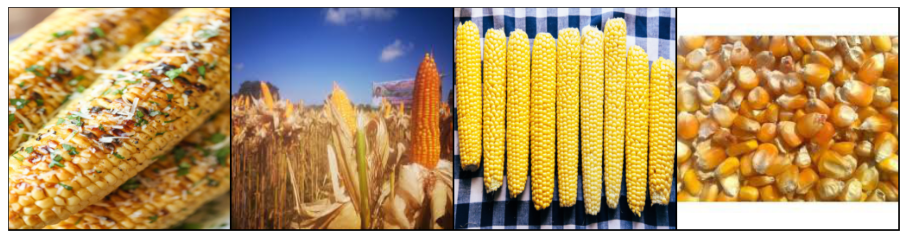

In [ ]:
show_batch_c(train_dl_A, lim=0)

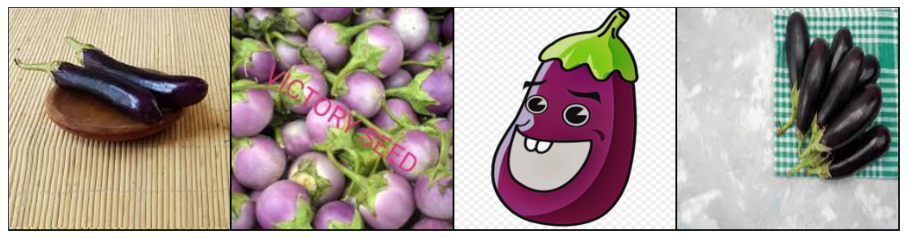

In [ ]:
show_batch_c(train_dl_B, lim=0)

In [ ]:
test_dl_A = DeviceDataLoader(test_dl_A, device)
test_dl_B = DeviceDataLoader(test_dl_B, device)

In [ ]:
# Примеры изображений из тестовой выборки

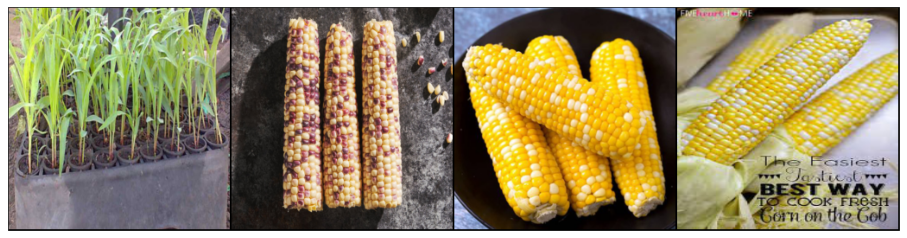

In [ ]:
show_batch_c(test_dl_A, lim=0)

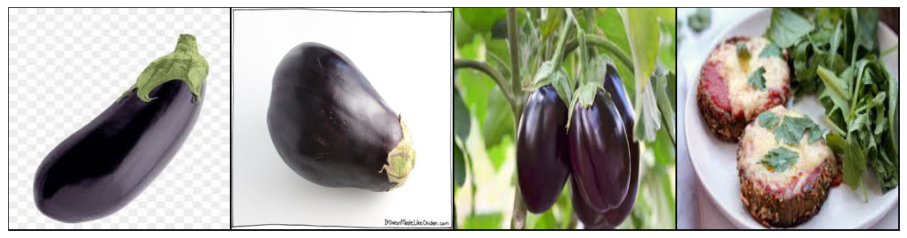

In [ ]:
show_batch_c(test_dl_B, lim=0)

## Часть 2. 

In [ ]:
# Дискриминатор и генератор

In [ ]:
class discriminator(torch.nn.Module):
  def __init__(self):
    super(discriminator, self).__init__()

    self.discr = nn.Sequential(
      #1
      nn.Conv2d(3, 64, kernel_size=4, stride=4, padding=1, bias=False),#64*64*64
      nn.InstanceNorm2d(64),
      nn.LeakyReLU(0.2, inplace=True),#True

      #2
      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),#128*32*32
      nn.InstanceNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),

      #3
      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),#256*16*16
      nn.InstanceNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      #4
      nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),#512*15*15
      nn.InstanceNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      #5
      nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),#1*14*14
      )
    
  def forward(self, x):
    x = self.discr(x)
    return x

In [ ]:
model_d_A=discriminator().to(device)
model_d_B=discriminator().to(device)
summary(model_d_A, input_size=(3, 256, 256), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 64, 64]           3,072
    InstanceNorm2d-2            [4, 64, 64, 64]               0
         LeakyReLU-3            [4, 64, 64, 64]               0
            Conv2d-4           [4, 128, 32, 32]         131,072
    InstanceNorm2d-5           [4, 128, 32, 32]               0
         LeakyReLU-6           [4, 128, 32, 32]               0
            Conv2d-7           [4, 256, 16, 16]         524,288
    InstanceNorm2d-8           [4, 256, 16, 16]               0
         LeakyReLU-9           [4, 256, 16, 16]               0
           Conv2d-10           [4, 512, 15, 15]       2,097,152
   InstanceNorm2d-11           [4, 512, 15, 15]               0
        LeakyReLU-12           [4, 512, 15, 15]               0
           Conv2d-13             [4, 1, 14, 14]           8,192
Total params: 2,763,776
Trainable param

In [ ]:
class generator(torch.nn.Module):
  def __init__(self):
    super(generator, self).__init__()

    self.e1 = nn.Sequential(nn.ReflectionPad2d(3),#3*262*262)
                            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=0),#64*256*256
                            nn.InstanceNorm2d(64),
                            nn.ReLU(True),
                            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),#128*128*128
                            nn.InstanceNorm2d(128),
                            nn.ReLU(True),
                            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),#256*64*64
                            nn.InstanceNorm2d(256),
                            nn.ReLU(True))
    
    self.r1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),#256*64*64
                            nn.InstanceNorm2d(256),
                            nn.ReLU(True),
                            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.InstanceNorm2d(256))#256*64*64                   

    self.r10 = nn.Sequential(nn.ReLU(True))#256*64*64
    

    self.d1 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#512*64*64
                            nn.PixelShuffle(2),#128*128*128
                            nn.InstanceNorm2d(128),
                            nn.ReLU(True),
                            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#256*128*128
                            nn.PixelShuffle(2),#128*128*128
                            nn.InstanceNorm2d(64),
                            nn.ReLU(True),
                            nn.ReflectionPad2d(3), #64*262*262
                            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=0),#3*256*256
                            nn.Tanh())

    
  def forward(self, x):
    
    x3 = self.e1(x)#256*64*64

    #1
    x6 = self.r10(x3 + self.r1(x3))#256*64*64
    #2
    x9 = self.r10(x6 + self.r1(x6))#256*64*64
    #3
    x12 = self.r10(x9 + self.r1(x9))#256*64*64
    #4
    x15 = self.r10(x12 + self.r1(x12))#256*64*64
    #5
    x18 = self.r10(x15 + self.r1(x15))#256*64*64
    #6
    x21 = self.r10(x18 + self.r1(x18))#256*64*64
    #7
    x24 = self.r10(x21 + self.r1(x21))#256*64*64
    #8
    x27 = self.r10(x24 + self.r1(x24))#256*64*64
    #9
    x29 = self.r10(x27 + self.r1(x27))#256*64*64
    #10
    x32 = self.d1(x29)#3*256*256

    return x32

In [ ]:
model_g_AB=generator().to(device)
model_g_BA=generator().to(device)
summary(model_g_AB, input_size=(3, 256, 256), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1           [4, 3, 262, 262]               0
            Conv2d-2          [4, 64, 256, 256]           9,472
    InstanceNorm2d-3          [4, 64, 256, 256]               0
              ReLU-4          [4, 64, 256, 256]               0
            Conv2d-5         [4, 128, 128, 128]         131,200
    InstanceNorm2d-6         [4, 128, 128, 128]               0
              ReLU-7         [4, 128, 128, 128]               0
            Conv2d-8           [4, 256, 64, 64]         524,544
    InstanceNorm2d-9           [4, 256, 64, 64]               0
             ReLU-10           [4, 256, 64, 64]               0
           Conv2d-11           [4, 256, 64, 64]         590,080
   InstanceNorm2d-12           [4, 256, 64, 64]               0
             ReLU-13           [4, 256, 64, 64]               0
           Conv2d-14           [4, 256,

In [ ]:
### Из ноутбука ДЗ GAN

def show_test(i):
  fig, ax = plt.subplots(figsize=(16, 16))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(i.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def show_test_2(i, titl=''):
    i = np.clip(i.cpu().detach().numpy(), 0, 1)
    i = torch.tensor(i)
    plt.figure(figsize=(16,16))
    plt.imshow(make_grid(i.cpu().detach(), nrow=8).permute(1, 2, 0))
    plt.axis("off")
    plt.title(titl)
    plt.show()

In [ ]:
lr_g = 0.00015
lr_d = 0.00015

criterion_g = nn.L1Loss()

In [ ]:
def crit_d(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def crit_dg(fake):
  return  torch.mean((fake - 1)**2)

In [ ]:
import gc
gc.collect()

In [ ]:
# Обучение модели с сохранением послде каждой эпохи на ГДиск

In [ ]:
def fit(model_d_A, model_d_B, model_g_AB, model_g_BA, criterion_g=criterion_g,epochs=30, lr_d=0.00015, lr_g=0.00015, start_idx=1):
    model_d_A.train()
    model_d_B.train()
    model_g_AB.train()# A to B
    model_g_BA.train()# B to A
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d_A, losses_d_B = [], []
    real_scores_A, real_scores_B = [], []
    fake_scores_A, fake_scores_B = [], []
    

    optimizer_d_A = torch.optim.Adam(model_d_A.parameters(), 
                                          lr=lr_d, betas=(0.5, 0.999))
    optimizer_d_B = torch.optim.Adam(model_d_B.parameters(), 
                                          lr=lr_d, betas=(0.5, 0.999))
    optimizer_g_AB = torch.optim.Adam(model_g_AB.parameters(), 
                                   lr=lr_g, betas=(0.5, 0.999))
    optimizer_g_BA = torch.optim.Adam(model_g_BA.parameters(), 
                                   lr=lr_g, betas=(0.5, 0.999))


    for epoch in range(epochs+1):
        loss_d_A_pb = []
        loss_d_B_pb = []

        loss_g_pb = []

        cur_real_score_A = []
        cur_real_score_B = []
        cur_fake_score_A = []
        cur_fake_score_B = []

        
        for i, (a, b) in enumerate(zip(train_dl_A, train_dl_B)):
           
            fake_B = model_g_AB(a)
            fake_A = model_g_BA(b)

            reconstructed_A = model_g_BA(fake_B)
            reconstructed_B = model_g_AB(fake_A)

            #d_A
            optimizer_d_A.zero_grad()

            loss_d_A =  crit_d(model_d_A(a), model_d_A(fake_A.detach()))
            loss_d_A_pb.append(loss_d_A.item())
            loss_d_A.backward()
            optimizer_d_A.step()

            #d_B
            optimizer_d_B.zero_grad()

            loss_d_B = crit_d(model_d_B(b), model_d_B(fake_B.detach()))
            loss_d_B_pb.append(loss_d_B.item())

            loss_d_B.backward()
            optimizer_d_B.step()

            #g_AB
            optimizer_g_AB.zero_grad()
            optimizer_g_BA.zero_grad()

            loss_g_1 = crit_dg(model_d_B(fake_B)) 
            loss_g_2 = 5*criterion_g(reconstructed_B, b)#g_AB
            loss_g_3 = 10*criterion_g(model_g_AB(b), b)#g_AB
            

            loss_g_4 = crit_dg(model_d_A(fake_A))
            loss_g_5 = 5*criterion_g(reconstructed_A, a)#g_BA
            loss_g_6 = 10*criterion_g(model_g_BA(a), a)#g_BA

            loss_g = loss_g_1 + loss_g_2 + loss_g_3 + loss_g_4 + loss_g_5 + loss_g_6
            loss_g_pb.append(loss_g.item())

            loss_g.backward()

            optimizer_g_AB.step()
            optimizer_g_BA.step()

            del a, b, fake_A, fake_B, reconstructed_A, reconstructed_B
           
        losses_g.append(np.mean(loss_g_pb))
        
        losses_d_A.append(np.mean(loss_d_A_pb))
        losses_d_B.append(np.mean(loss_d_B_pb))
        
        name=str(epoch)
        torch.save(model_g_AB, "/content/gdrive/MyDrive/save_models_corn_eggplant/"+ name + "_model_g_AB.pth")
        torch.save(model_g_BA, "/content/gdrive/MyDrive/save_models_corn_eggplant/"+name+"_model_g_BA.pth")
        torch.save(model_d_A, "/content/gdrive/MyDrive/save_models_corn_eggplant/"+name+"_model_d_A.pth")
        torch.save(model_d_B, "/content/gdrive/MyDrive/save_models_corn_eggplant/"+name+"_model_d_B.pth")
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d_A: {:.4f}, loss_d_B: {:.4f}".format(
            epoch+1, epochs, 
              losses_g[-1], losses_d_A[-1], losses_d_B[-1]))
    
        if epoch in [1, 5, 10, 15, 20, 25, 29]:
          for x in test_dl_B:
            show_test_2(x, titl='True eggplant')
            show_test_2(model_g_BA(x), titl='Fake corn')
            break
          for x in test_dl_A:
            show_test_2(x, titl='True corn')
            show_test_2(model_g_AB(x), titl='Fake eggplant')
            break

    return losses_g, losses_d_A, losses_d_B, real_scores_A, fake_scores_A, real_scores_B, fake_scores_B

Epoch [1/30], loss_g: 4.7973, loss_d_A: 0.5243, loss_d_B: 0.5356
Epoch [2/30], loss_g: 4.0081, loss_d_A: 0.4395, loss_d_B: 0.4737


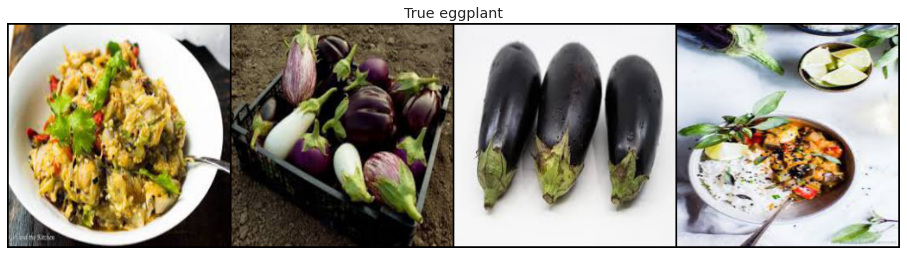

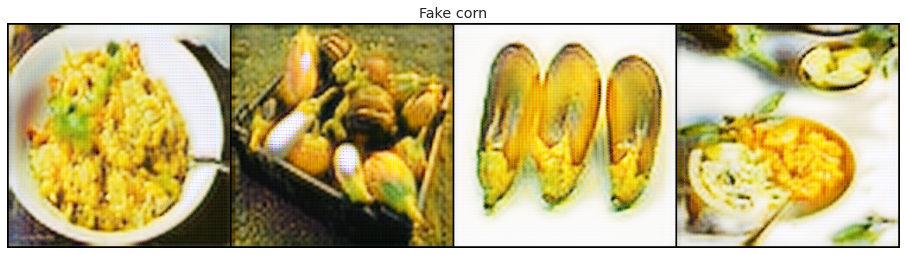

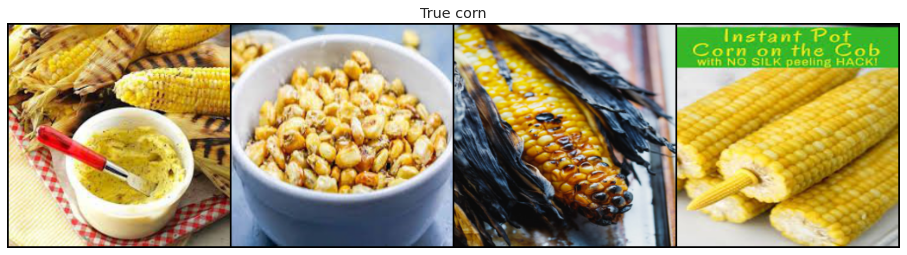

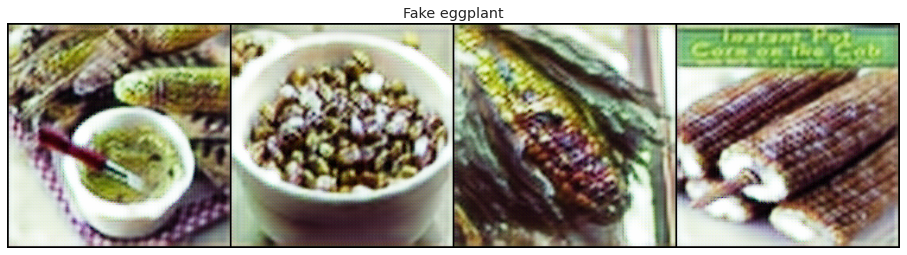

Epoch [3/30], loss_g: 3.6876, loss_d_A: 0.4379, loss_d_B: 0.4571
Epoch [4/30], loss_g: 3.5545, loss_d_A: 0.4349, loss_d_B: 0.4580
Epoch [5/30], loss_g: 3.4961, loss_d_A: 0.4336, loss_d_B: 0.4408
Epoch [6/30], loss_g: 3.4328, loss_d_A: 0.4330, loss_d_B: 0.4295


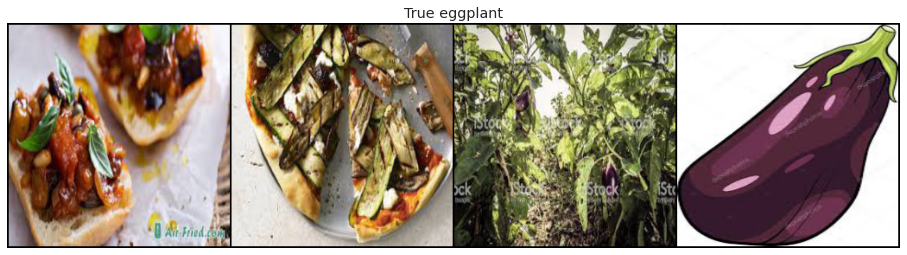

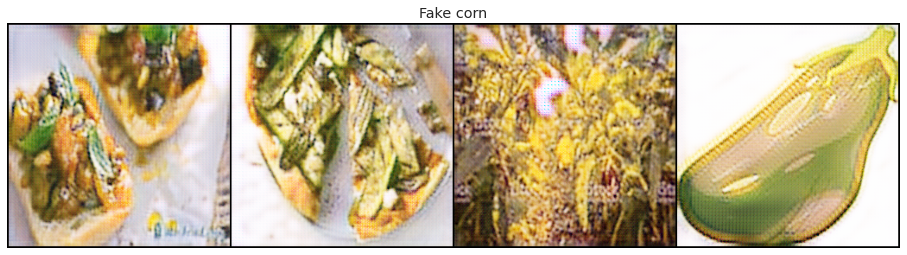

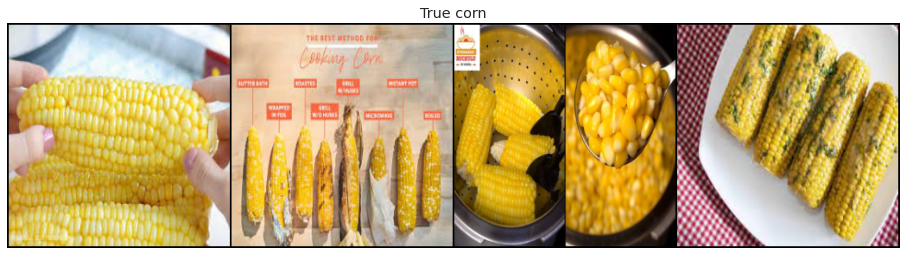

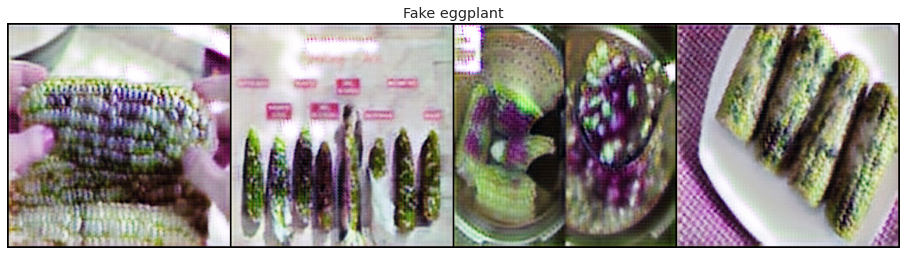

Epoch [7/30], loss_g: 3.3522, loss_d_A: 0.4310, loss_d_B: 0.4343
Epoch [8/30], loss_g: 3.3015, loss_d_A: 0.4189, loss_d_B: 0.4185
Epoch [9/30], loss_g: 3.2831, loss_d_A: 0.4067, loss_d_B: 0.4093
Epoch [10/30], loss_g: 3.3600, loss_d_A: 0.3878, loss_d_B: 0.3953
Epoch [11/30], loss_g: 3.4001, loss_d_A: 0.3727, loss_d_B: 0.3809


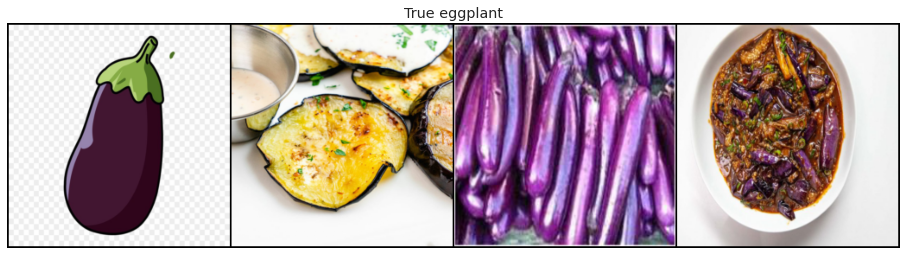

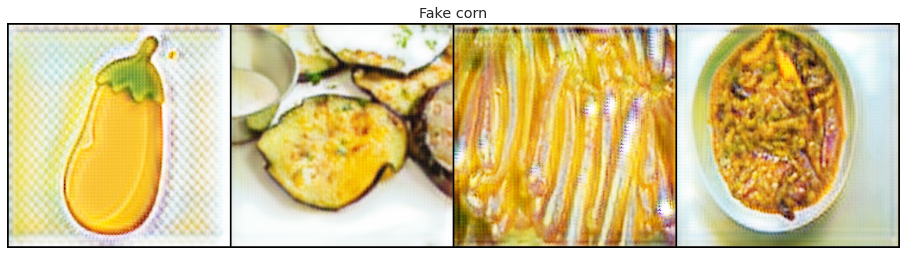

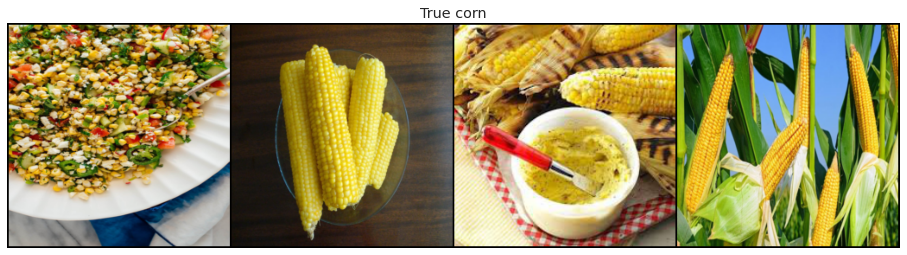

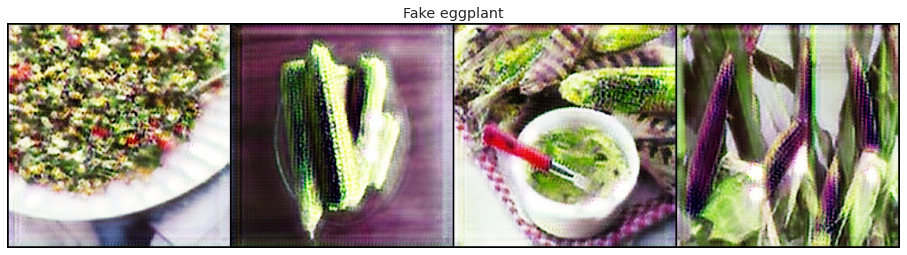

In [ ]:
history = fit(model_d_A, model_d_B, model_g_AB, model_g_BA, criterion_g, epochs=30)